In [22]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable


In [23]:
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import mne

In [25]:
import numpy as np
import pandas as pd

In [26]:
import pywt

In [27]:
from pywt import wavedec

In [28]:
raw = mne.io.read_raw_edf("1-2.edf", preload=True)

Extracting EDF parameters from /home/emanuel/workspace/VHDL_linear_algebra/aymen/1-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ...   599.998 secs...


In [29]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>

In [30]:
# Sélectionner les 5 premiers canaux EEG
#r=raw.pick_channels(raw.ch_names[:5])

In [31]:
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


Using matplotlib as 2D backend.


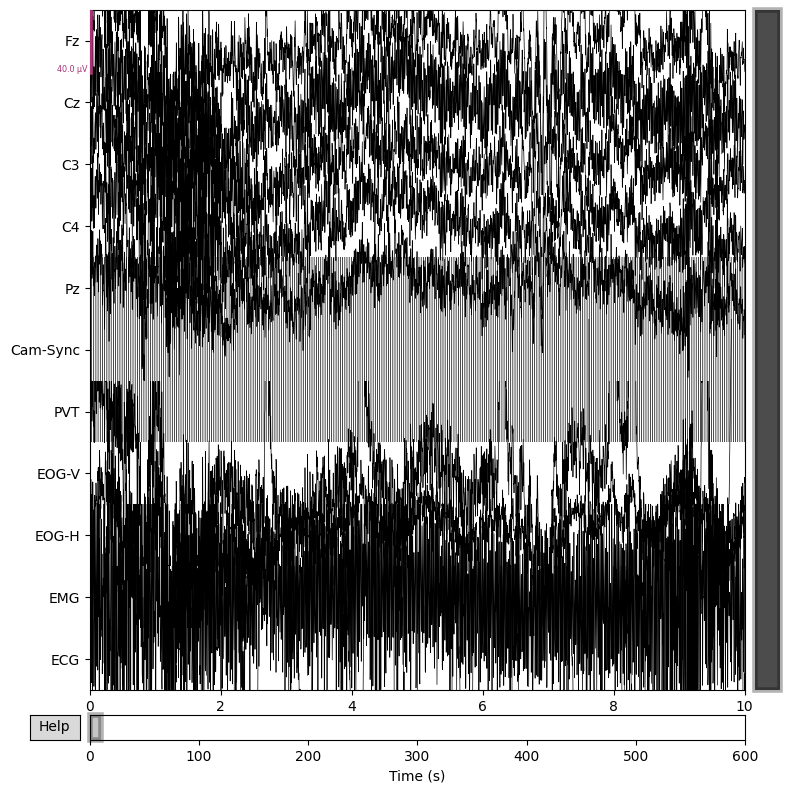

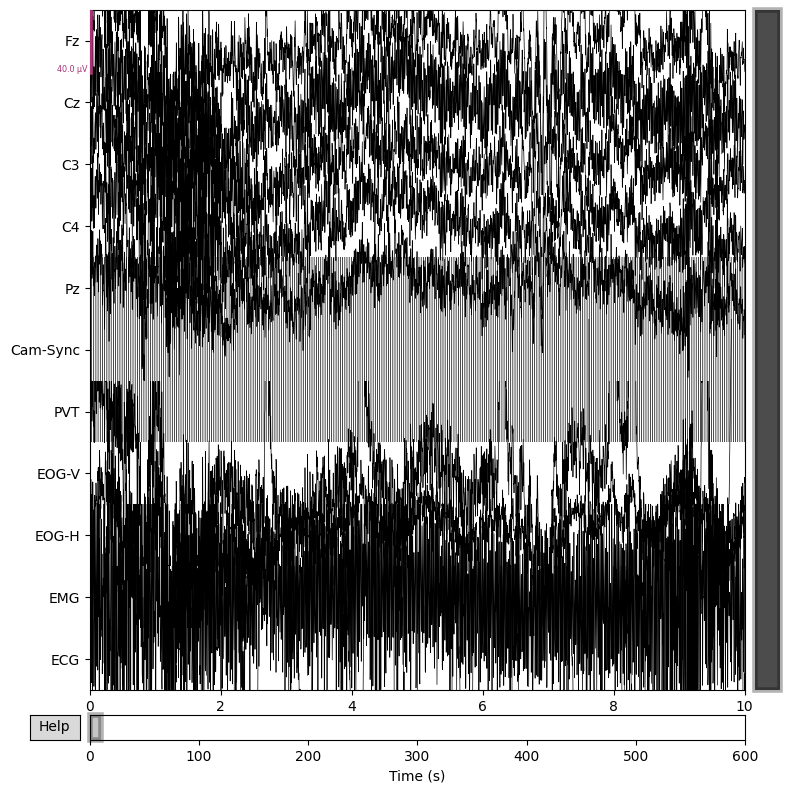

In [32]:
raw.plot()

In [33]:
%%time
rf = raw.filter(0.1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)

CPU times: user 131 ms, sys: 7.5 ms, total: 138 ms
Wall time: 139 ms


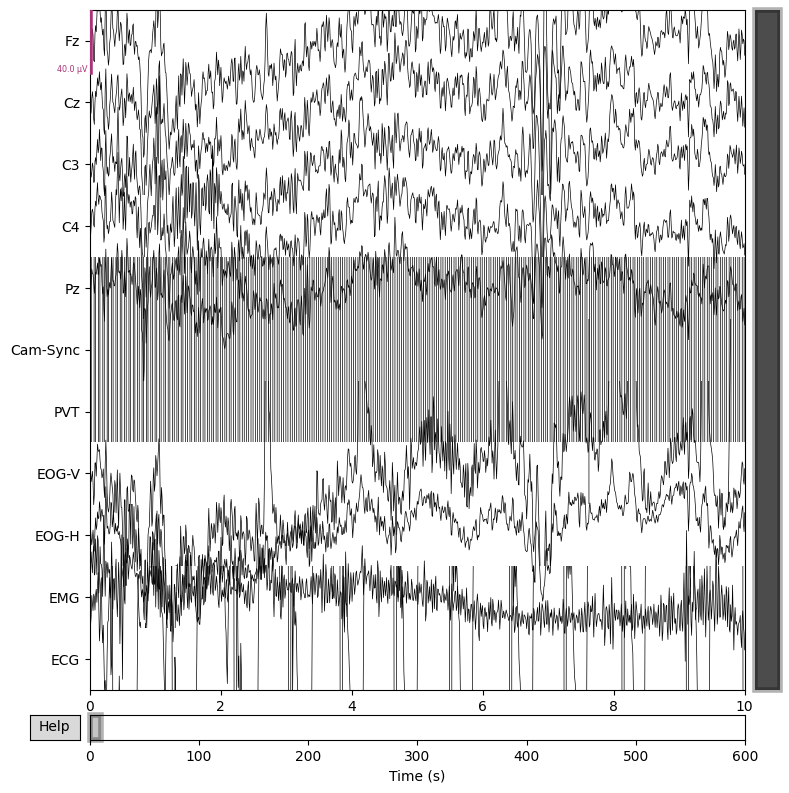

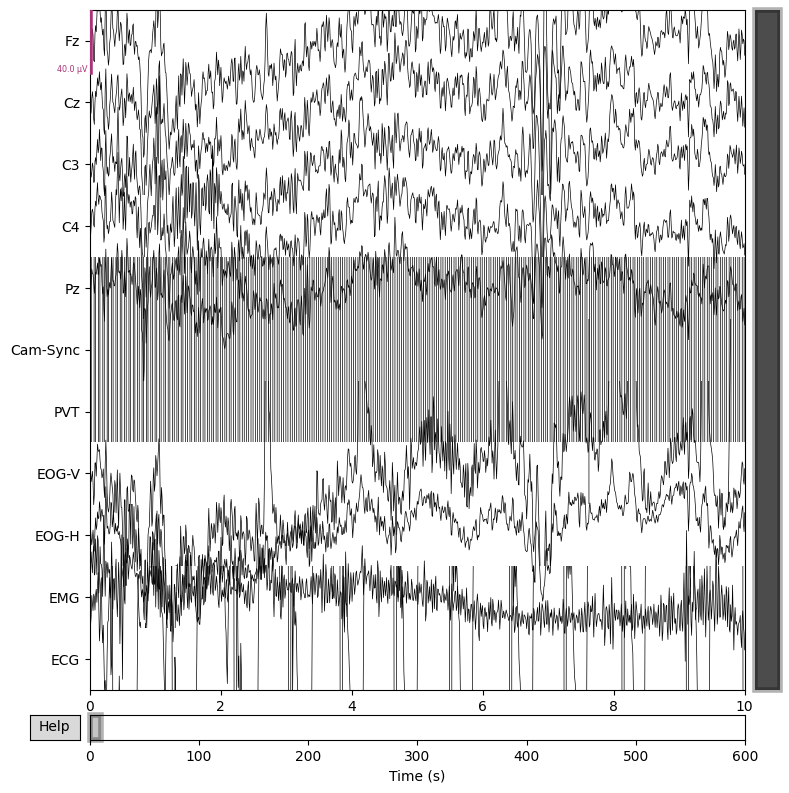

In [34]:
rf.plot()

In [35]:
print(rf.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


In [36]:
selected_channel_name = rf.info['ch_names']
sample_frequency = rf.info['sfreq']
epoch_duration = 10

In [37]:
selected_channel_name

['Fz',
 'Cz',
 'C3',
 'C4',
 'Pz',
 'Cam-Sync',
 'PVT',
 'EOG-V',
 'EOG-H',
 'EMG',
 'ECG']

In [38]:
sample_frequency

512.0

In [39]:
epoch_samples = int(epoch_duration*sample_frequency)

In [40]:
epoch_samples

5120

In [41]:
total_epochs = 307200// epoch_samples

In [42]:
total_epochs

60

In [43]:
epochs_matrix = np.zeros((total_epochs, 5, epoch_samples))  # 5 channels

In [44]:
# Segmenter les données en epochs de 10 secondes
events = mne.make_fixed_length_events(rf, duration=epoch_duration)

In [45]:
# Créer un objet Epochs
epochs = mne.Epochs(rf, events, tmin=0, tmax=epoch_duration, baseline=None, detrend=1)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [46]:
# Obtenir les données des epochs sous forme de tableau numpy
epochs_data = epochs.get_data()

Using data from preloaded Raw for 60 events and 5121 original time points ...
1 bad epochs dropped


In [47]:
# Vérifier la forme de la matrice d'epochs
print("Forme de la matrice d'epochs:", epochs_data.shape)

Forme de la matrice d'epochs: (59, 11, 5121)


In [48]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import scipy.stats as stats

In [50]:
zscores = stats.zscore(epochs_data)

In [51]:
zscores.shape

(59, 11, 5121)

In [52]:
# Définition de la famille d'ondelettes à utiliser
wavelet = 'db4'

# Initialisation des tableaux pour stocker les caractéristiques
cD_Energy = np.zeros((59, 5))
cA_Energy = np.zeros((59, 5))
D_Entropy = np.zeros((59, 5))
A_Entropy = np.zeros((59, 5))
D_mean = np.zeros((59, 5))
A_mean = np.zeros((59, 5))
D_std = np.zeros((59, 5))
A_std = np.zeros((59, 5))

In [53]:
%%time
for i in range(59):
  for j in range(5):
    coeffs = pywt.wavedec(zscores[i, j, :], wavelet)  # Calcul de la DWT avec pywt
    cD_Energy[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy[i,j] = np.sum(np.square(coeffs[0]))
    D_Entropy[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    A_Entropy[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    A_mean[i,j] = np.mean(coeffs[0])
    D_std[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    A_std[i,j] = np.std(coeffs[0])

CPU times: user 108 ms, sys: 779 μs, total: 109 ms
Wall time: 109 ms


In [54]:
df = pd.DataFrame(cD_Energy)
df1 = pd.DataFrame(cA_Energy)
df2 = pd.DataFrame(D_Entropy)
df3 = pd.DataFrame(A_Entropy)
df4 = pd.DataFrame(D_mean)
df5 = pd.DataFrame(A_mean)
df6 = pd.DataFrame(D_std)
df7 = pd.DataFrame(A_std)

In [55]:
ddd = pd.concat([df,df1,df2,df3,df4,df5,df6,df7], axis = 1)

In [56]:
ddd

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,980.581032,667.119269,847.945394,658.598514,569.344074,6618.257337,8118.239216,8674.658079,4040.775397,3315.008850,...,4.981762,4.016028,4.553026,4.037827,3.823758,18.439461,21.470742,21.603825,15.890305,14.382349
1,447.572857,354.247600,366.716919,313.760590,337.786846,4105.758345,11956.532460,6312.431896,9353.009598,11607.897111,...,3.297212,2.935984,2.866504,2.710584,2.892174,13.520271,21.937151,16.341546,19.580082,21.652162
2,486.105563,477.141367,479.555243,360.761071,463.138534,2949.736413,4561.969961,3609.778549,2651.761878,2455.866414,...,3.394254,3.014816,3.197556,2.443480,3.240610,13.572174,16.587980,14.712363,12.868942,11.998110
3,719.035962,713.173536,611.274420,555.541973,592.956188,13782.689294,15752.190781,10547.660883,14081.407067,8724.536930,...,4.362431,4.267999,3.854729,3.753326,3.873094,23.660925,25.041039,20.582461,23.636233,18.794531
4,565.858584,488.934584,490.826861,517.958795,572.487380,836.004920,3052.977314,2576.685679,4097.479012,2584.403839,...,3.836993,3.471745,3.503675,3.562602,3.742531,6.139829,11.227895,10.297603,13.118020,10.785181
5,534.575047,469.519601,478.804510,403.828627,411.147702,929.165988,1350.187551,678.531544,1026.435948,1541.894803,...,3.709094,3.313743,3.403393,2.997990,3.012510,6.838820,8.166366,6.153985,7.457113,9.811750
6,1172.070222,891.001858,1013.339180,824.422090,823.553335,1449.644221,1046.143919,1949.264179,1444.908110,823.108398,...,5.582138,4.824252,5.204366,4.629336,4.515406,9.502229,8.008939,10.928305,9.488831,7.170657
7,553.266801,701.900721,584.683876,602.900309,722.972826,371.673007,383.816302,863.784796,1150.939188,1229.014626,...,3.419054,3.773017,3.348547,3.425295,3.796982,4.819294,4.889690,6.686949,7.431680,8.162535
8,817.455348,721.276865,681.784568,639.746976,938.458614,2076.482093,2216.921100,2852.850943,1076.172651,2032.442452,...,4.360370,3.801079,3.849237,3.564143,4.265760,9.638998,10.997717,11.605039,8.193687,11.233606
9,1283.317325,1226.128349,1205.486976,1094.007261,1166.806735,1379.463041,6632.404172,2337.678661,10296.785635,18145.241233,...,5.086051,4.988057,4.986508,4.698388,4.908872,9.239727,16.959318,10.695078,21.089780,27.293830
